In [1]:
# !pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap


import warnings
warnings.filterwarnings("ignore")

features_sc_names = [
        'SCR_Amplitude_mean',
        'SCR_Amplitude_std',
        'SCR_RiseTime_mean',
        'SCR_RiseTime_std',
        'SCR_RecoveryTime_mean',
        'SCR_RecoveryTime_std'
        ] 

features_bvp_names = None

In [3]:
def extract_sc(signal):
    df, info = nk.eda_process(signal, sampling_rate=31)

    features_sc = np.array([
        np.nanmean(info['SCR_Amplitude']),
        np.nanstd(info['SCR_Amplitude']),
        np.nanmean(info['SCR_RiseTime']),
        np.nanstd(info['SCR_RiseTime']),
        np.nanmean(info['SCR_RecoveryTime']),
        np.nanstd(info['SCR_RecoveryTime'])
        ])
    
    return features_sc

def extract_bvp(signal):
    global features_bvp_names
    df, info = nk.ppg_process(signal, sampling_rate=31)
    feature_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
    if features_bvp_names == None:
        features_bvp_names = list(feature_bvp)
        
    feature_bvp = feature_bvp[features_bvp_names]
        
    return feature_bvp.to_numpy()[0]

## Data Processing
In this section, we will import the "mazeball" dataset with the `pandas` library. 

In [4]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']

In [5]:
mb_data.shape

(36, 3)

In [6]:
alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],
    
    # games
    'game_variant': [],
    'gameplay_score': [], 
    'keystrokes': [], # keystrokes per second
    
    'class': [], # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
    }

effect = "fun"

for a in tqdm(range(36)): # player number
    player_demographics = p_demo[a] # player demographics
    player_game = p_games[a]
    player_tutorial = p_tutorial[a]
    
    for b in range(len(player_game)): # game number
        game_pref = p_games[a][b]['preferences']
        game_a = p_games[a][b]['data']['A'][0]
        game_b = p_games[a][b]['data']['B']
        game_keystroke_a = p_games[a][b]['data']['A'][0]['keystrokes']
        game_keystroke_b = p_games[a][b]['data']['B']['keystrokes']
        
        
        
        
        # append information for Game A
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]
        
        alldata['game_variant'] += [game_a['variant']]
        alldata['gameplay_score'] += [game_a['gameplay']['score'][-1]] # the last element in score array is the final score
        
        # calculate keystrokes per second and append information into alldata
        num_keystroke_a = 0
        for i in game_keystroke_a:
            if i == "time":
                break
            num_keystroke_a += sum(game_keystroke_a[i])
        kps_a = num_keystroke_a / game_keystroke_a['time'][-1]
        alldata['keystrokes'] += [kps_a]
        
        # append information for Game B
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]
        
        alldata['game_variant'] += [game_b['variant']]
        alldata['gameplay_score'] += [game_b['gameplay']['score'][-1]] # the last element in score array is the final score
        
        # calculate keystrokes per second and append information into alldata
        num_keystroke_b = 0
        for i in game_keystroke_b:
            if i == "time":
                break
            num_keystroke_b += sum(game_keystroke_b[i])
        kps_b = num_keystroke_b / game_keystroke_b['time'][-1]
        alldata['keystrokes'] += [kps_b]
        
        if game_pref[effect] == "A": # if game A is more intense than game B
            alldata['class'] += [1] # class label for Game A
            alldata['class'] += [0] # class label for Game B
        
        elif game_pref[effect] == "B": # if game B is more intense
            alldata['class'] += [0]
            alldata['class'] += [1]
        
        elif game_pref[effect] == "Both equally":
            alldata['class'] += [1]
            alldata['class'] += [1]
        
        elif game_pref[effect] == "Neither":
            alldata['class'] += [0]
            alldata['class'] += [0]


100%|██████████| 36/36 [00:00<00:00, 1597.69it/s]


### Preparation for training
The cell below will create the dataset with the `X` as the training data which consists of:
1. player_age
2. gender
3. player_playgames
4. player_playfrequency
5. game_variant
6. SC (Skin Inductance)
7. BVP (Blood Pressure Pulse)

and `Y` for having the class that we had specify at the cell before.

In [7]:
# create dataset
X = [] # training data
Y = [] # class label
Z = [] # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                alldata['player_gender'][i],
                alldata['player_playgames'][i],
                alldata['player_playfrequency'][i],
                alldata['game_variant'][i],
                alldata['gameplay_score'][i],
                alldata['keystrokes'][i]])])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]
    
feature_names = ['player_age', 'player_gender', 'player_playgames', 'player_playfrequency', 'game_variant', 'gameplay_score', 'keystrokes']
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

print(X.shape)
print(Y.shape)
print(Z.shape)

(288, 7)
(288,)
(288,)


In [8]:
X = np.nan_to_num(X, neginf=0, posinf=0)
print(np.any(np.isnan(X)))
print(len(feature_names))

False
7


## Model Training

In [9]:
# Supervised Learning Algorithm = Light Gradient Boosting Method (LGBM)
# Information: Gameplay & Keystroke information
# Preference = Fun

import lightgbm as lgb
from lightgbm import LGBMClassifier 

# specify your configurations as a dict
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}
# divide into training and testing; 
# leave-one-person-out: X-1 persons for training, 1 person for testing
predictions = []
labels = []

for idx in tqdm(player_id):
    istrain = Z!=idx
    istest = Z==idx
    
    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]
    
    X_train = np.where(np.isnan(X_train), 0, X_train)
    X_test = np.where(np.isnan(X_test), 0, X_test)
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_eval = lgb.Dataset(X_test, Y_test)

    lgbm = lgb.train(
        params,
        lgb_train,
        10000,
        valid_sets=[lgb_eval],
    )
    
    # test the model
    Y_pred = lgbm.predict(X_test)
    # print('Y logits:', Y_pred)
    pred_class = (Y_pred > 0.5).astype("int")
    # print('Y predictions:', pred_class)
    
    predictions += [pred_class]
    labels += [Y_test]

100%|██████████| 36/36 [00:09<00:00,  3.73it/s]


In [10]:
accuracy = np.mean(np.concatenate(predictions) == np.concatenate(labels))
print(accuracy)

0.65625


In [11]:
X

array([[ 26.        ,   1.        ,   1.        , ...,   1.        ,
        150.        ,   0.55866572],
       [ 26.        ,   1.        ,   1.        , ...,   2.        ,
        325.        ,   0.54085726],
       [ 26.        ,   1.        ,   1.        , ...,   8.        ,
          0.        ,   0.51074262],
       ...,
       [ 25.        ,   0.        ,   1.        , ...,   8.        ,
         50.        ,   0.47784149],
       [ 25.        ,   0.        ,   1.        , ...,   7.        ,
        150.        ,   0.38883806],
       [ 25.        ,   0.        ,   1.        , ...,   5.        ,
        175.        ,   0.47968051]])

In [12]:
feature_names

['player_age',
 'player_gender',
 'player_playgames',
 'player_playfrequency',
 'game_variant',
 'gameplay_score',
 'keystrokes']

In [13]:
model_explainable = shap.TreeExplainer(lgbm, data=X)
shap_values = model_explainable.shap_values(X, Y)

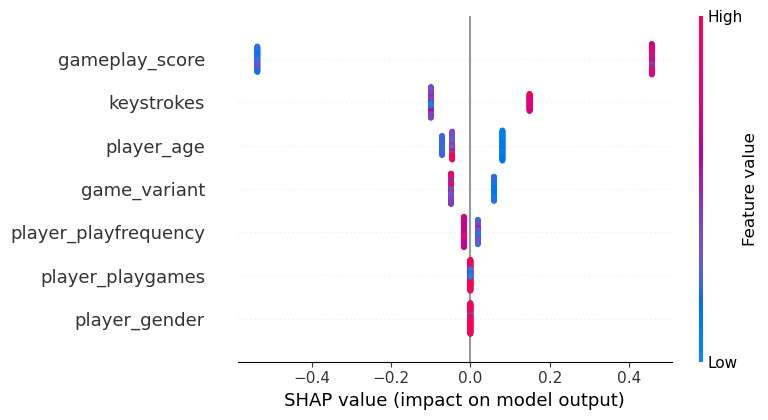

In [14]:
shap.summary_plot(shap_values, features=X, feature_names=feature_names)

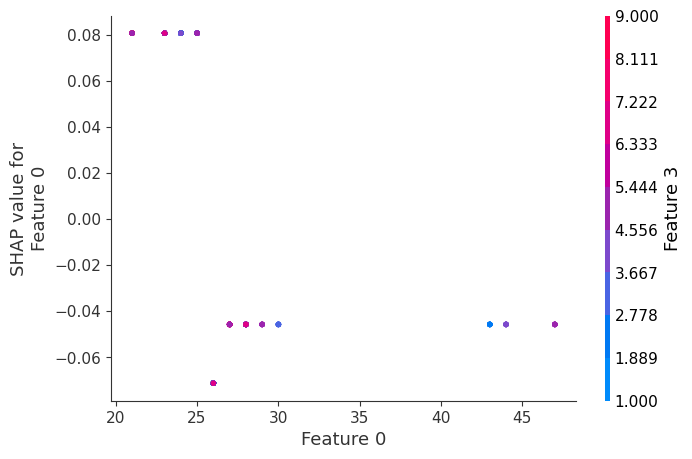

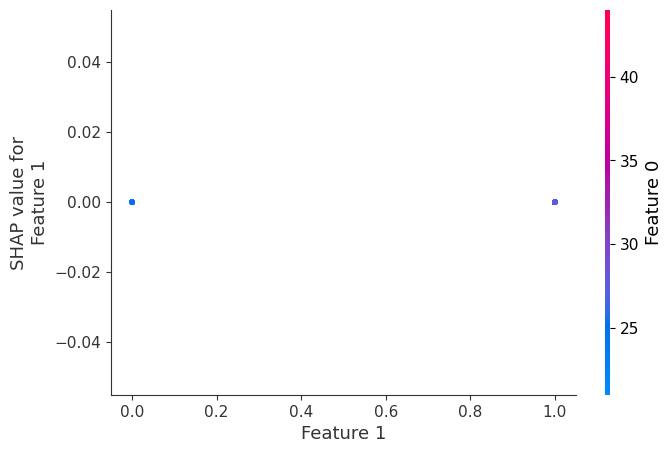

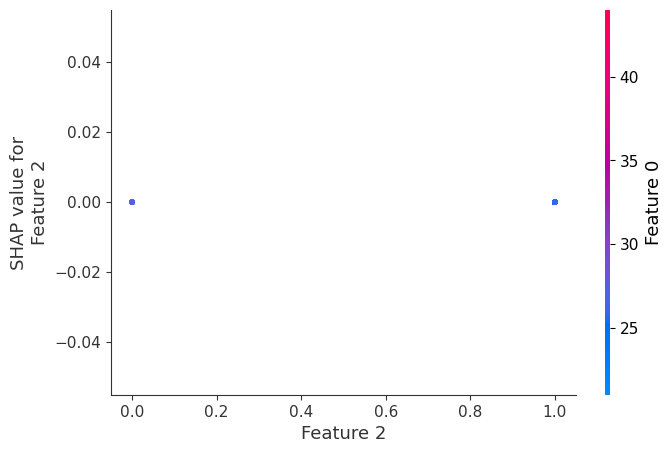

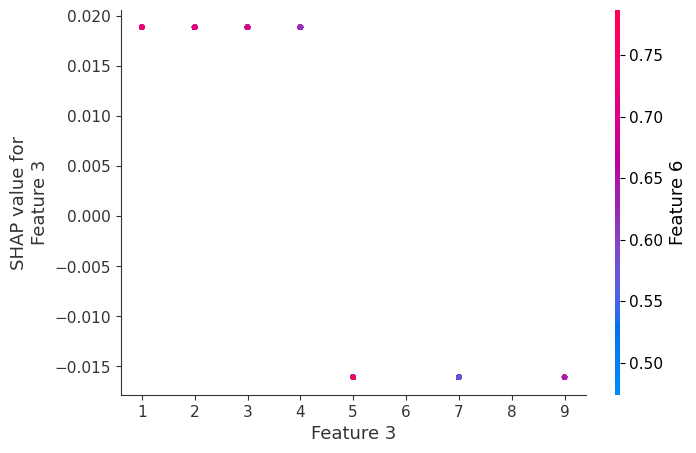

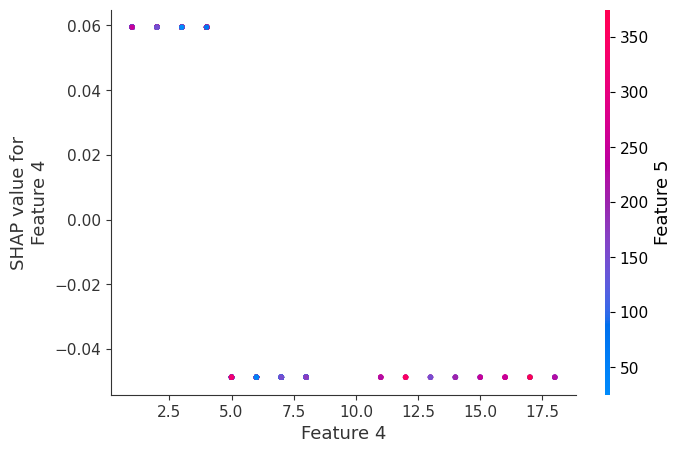

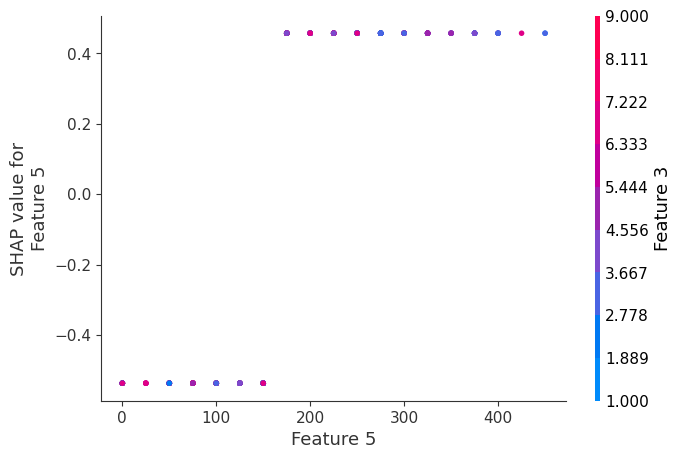

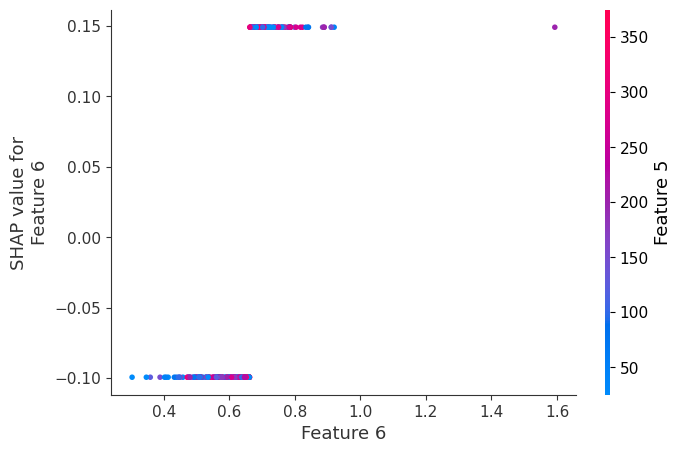

In [15]:
for i in range(len(feature_names)):
    shap.dependence_plot(i, shap_values, X)